In [71]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [72]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

In [73]:
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df['class'] = cancer.target

df.tail()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,class
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0
568,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,0.05884,...,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039,1


In [74]:
df.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'class'],
      dtype='object')

In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [76]:
data = torch.from_numpy(df.values).float()

data.shape

torch.Size([569, 31])

In [77]:
x = data[:, :10]
y = data[:,-1:]

print(x.shape, y.shape)

torch.Size([569, 10]) torch.Size([569, 1])


In [78]:
ratios = [.6, .2, .2]

In [79]:
train_cnt = int(data.size(0) * ratios[0])
valid_cnt = int(data.size(0) * ratios[1])
test_cnt = data.size(0) - train_cnt - valid_cnt
cnts = [train_cnt, valid_cnt, test_cnt]
print(f'Train : {train_cnt}, valid : {valid_cnt}, test : {test_cnt}')

Train : 341, valid : 113, test : 115


In [80]:
indices = torch.randperm(data.size(0))

x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

x = x.split(cnts, dim=0)
y = y.split(cnts, dim=0)

for x_i,y_i in zip(x,y):
    print(x_i.size(),y_i.size())

torch.Size([341, 10]) torch.Size([341, 1])
torch.Size([113, 10]) torch.Size([113, 1])
torch.Size([115, 10]) torch.Size([115, 1])


## Hyper Params

In [81]:
n_epochs = 10000
batch_size = 128
print_interval = 500
early_stop = 100

## Get DataLoaders

In [82]:
from torch.utils.data import Dataset, DataLoader

In [83]:
class CustomDataset(Dataset):

    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

        super().__init__()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [84]:
train_loader = DataLoader(
    dataset=CustomDataset(x[0],y[0]),
    batch_size=batch_size,
    shuffle=True, # Only training sets need to be shuffled
)
valid_loader = DataLoader(
    dataset=CustomDataset(x[1],y[1]),
    batch_size=batch_size,
    shuffle=False,
)
test_loader = DataLoader(
    dataset=CustomDataset(x[2],y[2]),
    batch_size=batch_size,
    shuffle=False,
)

print(
    f" Train : {len(train_loader.dataset)}, Valid : {len(valid_loader.dataset)}, Test : {len(test_loader.dataset)}"
)

 Train : 341, Valid : 113, Test : 115


### Build Model & Optimizer

In [85]:
model = nn.Sequential(
    nn.Linear(x[0].size(-1), 6),
    nn.LeakyReLU(),
    nn.Linear(6,5),
    nn.LeakyReLU(),
    nn.Linear(5,4),
    nn.LeakyReLU(),
    nn.Linear(4,3),
    nn.LeakyReLU(),
    nn.Linear(3,y[0].size(-1)),
    nn.Sigmoid()
)

model

Sequential(
  (0): Linear(in_features=10, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
  (9): Sigmoid()
)

In [86]:
optimizer = optim.Adam(model.parameters())

## Train 

In [87]:
from copy import deepcopy

lowest_loss = np.inf
best_model = None

lowest_epoch = np.inf

In [88]:
train_history, valid_history = [], []

for i in range(n_epochs):
    model.train()
    
    train_loss, valid_loss = 0, 0
    y_hat = []

    for x_i,y_i in train_loader:
        y_hat_i = model(x_i)
        loss = F.binary_cross_entropy(y_hat_i,y_i)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        train_loss += float(loss)
    
    train_loss = train_loss / len(train_loader)

    model.eval()
    with torch.no_grad():
        valid_loss = 0

        for x_i,y_i in valid_loader:
            y_hat_i = model(x_i)
            loss = F.binary_cross_entropy(y_hat_i,y_i)

            valid_loss += float(loss)

            y_hat += [y_hat_i]
    
    valid_loss = valid_loss / len(valid_loader)

    train_history += [train_loss]
    valid_history += [valid_loss]

    if (i + 1) % print_interval == 0:
        print('Epoch %d: train loss=%4e valid_loss=%4e lowest_loss=%4e'% (
            i + 1,
            train_loss,
            valid_loss,
            lowest_loss,
        ))
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i

        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print('There is no improvement during last %d epoch' % early_stop)
            break
    
print('The best validation loss from epoch %d : %.4e' % (lowest_epoch + 1, lowest_loss))
model.load_state_dict(best_model)

Epoch 500: train loss=3.017684e-01 valid_loss=2.036782e-01 lowest_loss=1.997267e-01
Epoch 1000: train loss=2.875065e-01 valid_loss=1.693353e-01 lowest_loss=1.685079e-01
Epoch 1500: train loss=2.414747e-01 valid_loss=1.382020e-01 lowest_loss=1.293671e-01
There is no improvement during last 100 epoch
The best validation loss from epoch 1609 : 1.0463e-01


<All keys matched successfully>

### Loss History

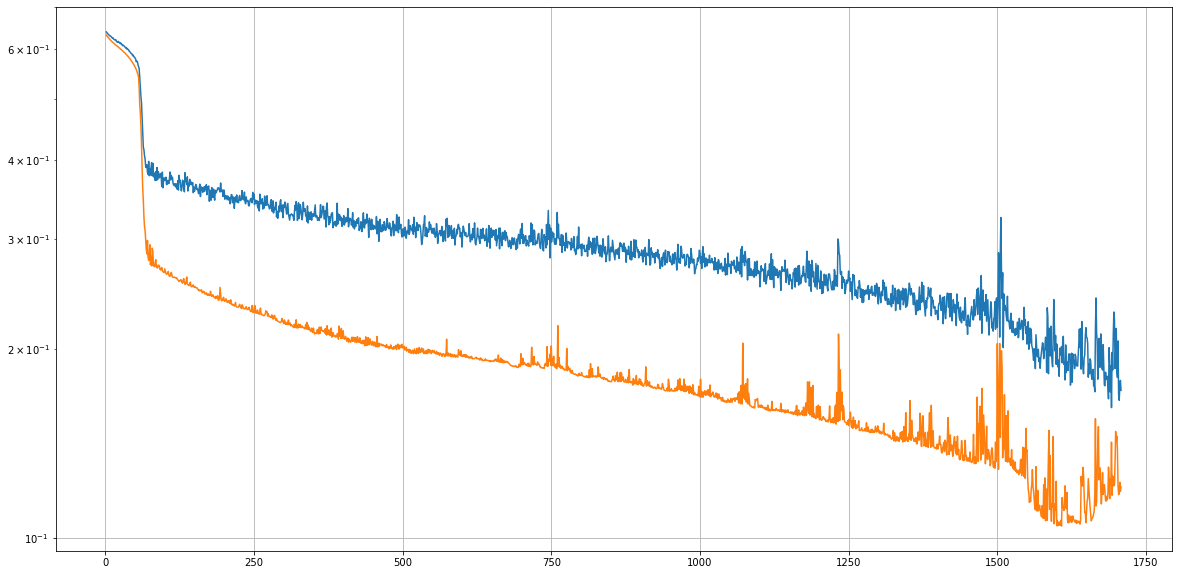

In [89]:
plot_from = 2

plt.figure(figsize=(20,10))
plt.grid(True)
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:]
)
plt.yscale('log')
plt.show()

### Result

In [90]:
test_loss = 0
y_hat = []

model.eval()
with torch.no_grad():
    for x_i, y_i in test_loader:
        y_hat_i = model(x_i)
        loss = F.binary_cross_entropy(y_hat_i,y_i)

        test_loss += loss

        y_hat += [y_hat_i]

test_loss = test_loss / len(test_loader)
y_hat = torch.cat(y_hat, dim=0)

print('Test loss : %.4e' % test_loss)

Test loss : 1.5045e-01


In [91]:
correct_cnt = (y[2] == (y_hat > .5)).sum()
total_cnt = float(y[2].size(0))

print('Test Accuracy : %.4f' % (correct_cnt/total_cnt))

Test Accuracy : 0.9304
